# Session 4 — Paragraph-Level Analysis
## Measure 5: Paragraph Function Classification

In this notebook, you will:
- define a small set of **paragraph function labels**
  (dialogue, action, description, internal_monologue, other)
- create short **prototype texts** for each label
- embed both prototypes and real paragraphs with MiniLM
- assign to each paragraph the label whose prototype is most similar.

This mimics how agentic LLM systems classify chunks of text into roles
(instruction, context, plan, reflection, etc.).


In [3]:
import re
from typing import List, Dict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- 1. Load Data ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

# Corrected paths
fellowship_text = load_book('../data/Fellowship.txt')
towers_text = load_book('../data/TwoTowers.txt')
king_text = load_book('../data/TheKing.txt')

In [7]:
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Hybrid Mode)
    1. Checks for standard double-spacing (\n\n).
    2. If missing, falls back to single-line splitting (\n).
    3. Cleans whitespace and filters tiny artifacts.
    """
    # Normalize newlines
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # STRATEGY 1: Standard Split (Double Newline)
    # Good for standard formatted books
    paras = re.split(r'\n\s*\n+', text)
    
    # Check if Strategy 1 failed (e.g., found < 100 chunks in a whole book)
    if len(paras) < 100:
        # STRATEGY 2: Aggressive Split (Single Newline)
        # Good for "The King" and non-standard text files
        paras = text.split('\n')

    # Final Cleanup
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        # Filter out empty lines or short dialogue artifacts (like "No.")
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    return cleaned_paras
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

# Prototypes define the "center" of each category
PROTOTYPES: Dict[str, List[str]] = {
    'dialogue': [
        '"What are you doing?" he asked.',
        '"I do not know," said Frodo.',
        '"Go back!" she cried out loud.',
        'He spoke clearly: "We must leave at dawn."'
    ],
    'action': [
        'He drew his sword and ran forward.',
        'The orcs charged across the field.',
        'They climbed the steep stairs, panting for breath.',
        'She jumped over the log and sprinted into the trees.'
    ],
    'description': [
        'The mountain stood tall and grey against the sky.',
        'The room was dark, filled with the smell of old books.',
        'It was a cold morning, and the mist covered the valley.',
        'The path wound through the forest, covered in fallen leaves.'
    ],
    'internal_monologue': [
        # STRICTER: Use first-person "I" and explicit thought markers
        'I wonder if I will ever see home again, he thought.',
        'In his mind, he debated whether to turn back or keep going.',
        '"Why is he looking at me like that?" she wondered.',
        'He thought to himself: this is a bad idea.'
    ],
    'other': [
        'Chapter 1: A Long-Expected Party',
        'The history of the Ring goes back many years.',
        '*** END OF BOOK ***'
    ],
}

# You must re-run the `build_prototype_embeddings` and `classify_all` functions
# after changing this list for it to take effect!


def build_prototype_embeddings() -> Dict[str, np.ndarray]:
    proto_embs = {}
    for label, examples in PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

prototype_embeddings = build_prototype_embeddings()

def classify_paragraph_embedding(paragraph: str, proto_embs: Dict[str, np.ndarray]) -> str:
    emb = model.encode(paragraph)
    best_label = None
    best_sim = -1.0
    for label, proto in proto_embs.items():
        sim = cosine_similarity(emb, proto)
        if sim > best_sim:
            best_sim = sim
            best_label = label
    return best_label or 'other'

def classify_all(paragraphs: List[str], proto_embs: Dict[str, np.ndarray]) -> List[str]:
    labels = []
    for p in paragraphs:
        if len(p.split()) < 5: continue
        labels.append(classify_paragraph_embedding(p, proto_embs))
    return labels

In [8]:
print("Classifying Fellowship...")
f_labels = classify_all(split_into_paragraphs(fellowship_text), prototype_embeddings)

print("Classifying Two Towers...")
t_labels = classify_all(split_into_paragraphs(towers_text), prototype_embeddings)

print("Classifying The King...")
k_labels = classify_all(split_into_paragraphs(king_text), prototype_embeddings)

def label_counts(labels: List[str], title: str) -> Counter:
    c = Counter(labels)
    total = sum(c.values()) or 1
    print(f"\n{title}:")
    for k, v in c.items():
        print(f"{k:18s}: {v:4d} ({v/total*100:5.1f}%)")
    return c

f_counts = label_counts(f_labels, "Fellowship")
t_counts = label_counts(t_labels, "Two Towers")
k_counts = label_counts(k_labels, "The King")

Classifying Fellowship...
Classifying Two Towers...
Classifying The King...

Fellowship:
other             :  324 ( 13.2%)
description       :  711 ( 29.1%)
action            :  274 ( 11.2%)
internal_monologue:   54 (  2.2%)
dialogue          : 1083 ( 44.3%)

Two Towers:
other             :  183 (  9.0%)
action            :  496 ( 24.5%)
description       :  535 ( 26.4%)
dialogue          :  736 ( 36.3%)
internal_monologue:   76 (  3.8%)

The King:
other             :  297 ( 13.0%)
description       :  529 ( 23.2%)
dialogue          :  980 ( 42.9%)
action            :  395 ( 17.3%)
internal_monologue:   81 (  3.5%)


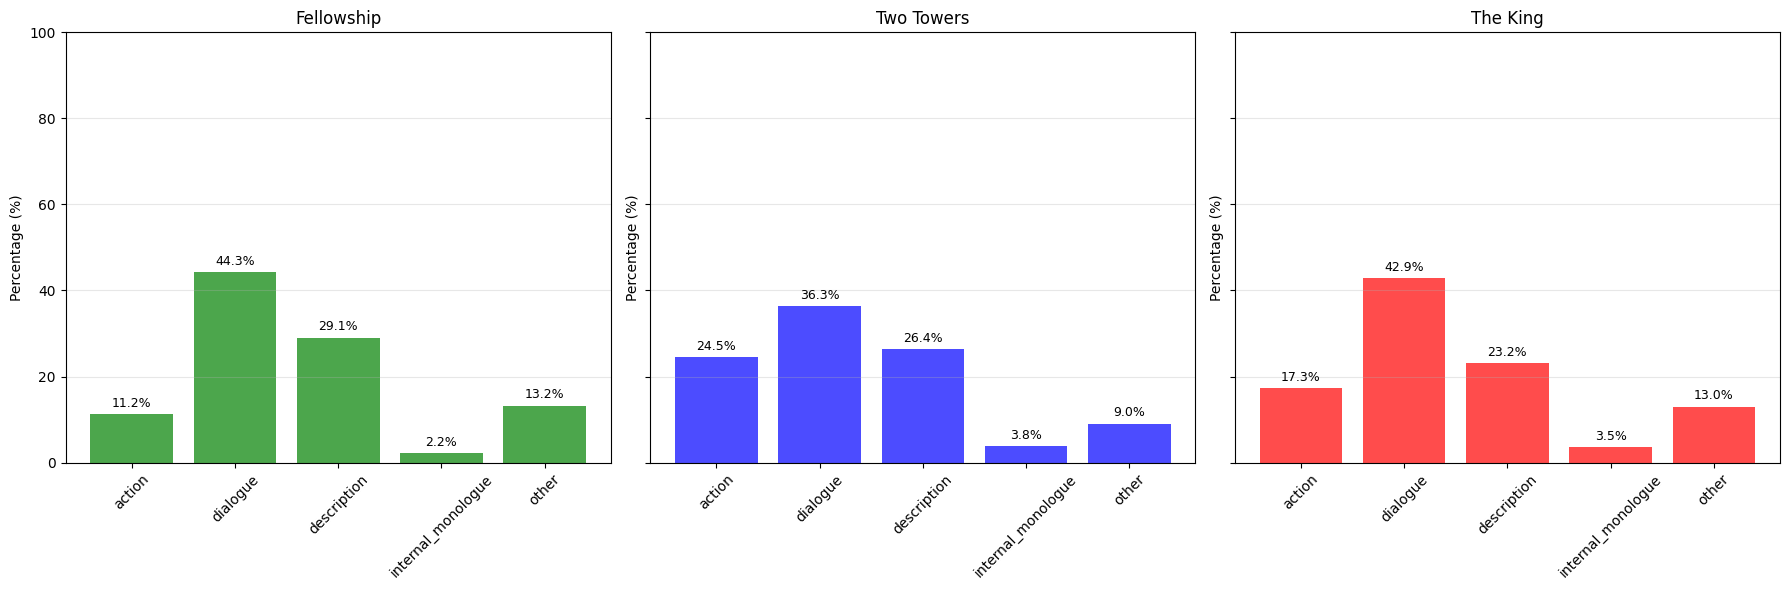

In [9]:
# Define the standard order for all graphs
ALL_LABELS = ['action', 'dialogue', 'description', 'internal_monologue', 'other']

def plot_fixed_percentage_bars(counts: Counter, title: str, ax, color):
    total = sum(counts.values())
    
    # If the book is empty/not loaded, handle it gracefully
    if total == 0:
        values = [0] * len(ALL_LABELS)
    else:
        # Get count for each label in ALL_LABELS, defaulting to 0 if missing
        values = [(counts.get(l, 0) / total) * 100 for l in ALL_LABELS]
    
    # Plot
    bars = ax.bar(ALL_LABELS, values, color=color, alpha=0.7)
    
    ax.set_title(title)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add text labels (only if > 0 to avoid clutter)
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=9)

# Plot again with fixed axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_fixed_percentage_bars(f_counts, 'Fellowship', axes[0], 'green')
plot_fixed_percentage_bars(t_counts, 'Two Towers', axes[1], 'blue')
plot_fixed_percentage_bars(k_counts, 'The King', axes[2], 'red')

plt.tight_layout()
plt.show()

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [ ]:
del fellowship_text, towers_text, king_text
del f_labels, t_labels, k_labels
del f_counts, t_counts, k_counts
del model
gc.collect()

Reloading The King...
 Nuclear Split finished. Found 2282 paragraphs.
✅ Success! Data looks realistic (2282 chunks).
Re-classifying (this will take longer now)...

The King (Aggressive Split):
other             :  297 ( 13.0%)
description       :  529 ( 23.2%)
dialogue          :  980 ( 42.9%)
action            :  395 ( 17.3%)
internal_monologue:   81 (  3.5%)


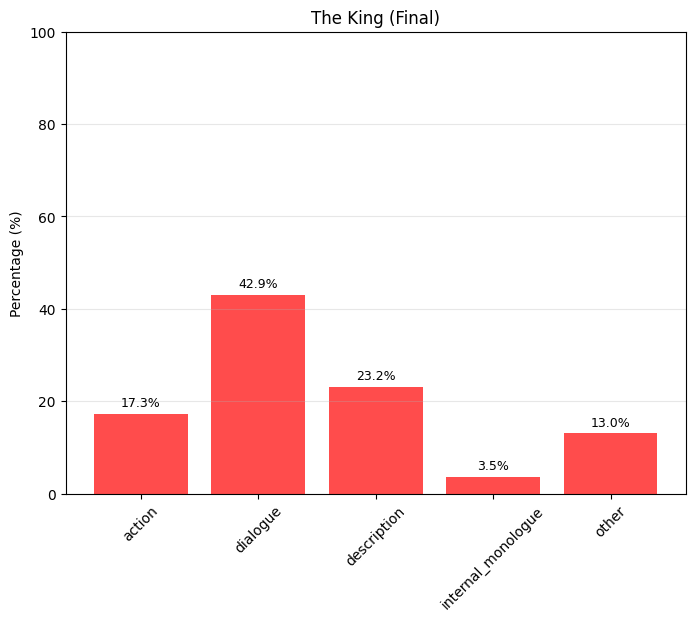


Found 980 dialogue snippets. First 3:
 - 'Where are we, Gandalf?' he asked.
 - 'Sleep again, and do not be afraid!' said Gandalf. 'For you are not going like Frodo to Mordor, but to Minas Tirith, and there you will be as safe as you can be anywhere in these days. If Gondor falls, or the Ring is taken, then the Shire will be no refuge.'
 - 'Yea truly, we know you, Mithrandir,' said the leader of the men, 'and you know the pass-words of the Seven Gates and are free to go forward. But we do not know your companion. What is he? A dwarf out of the mountains in the North? We wish for no strangers in the land at this time, unless they be mighty men of arms in whose faith and help we can trust.'


In [10]:
# --- THE NUCLEAR SPLITTER ---
def split_aggressive(text: str, min_words: int = 5) -> List[str]:
    """
    Forces a split on EVERY newline. 
    Essential for text files that don't use double-spacing.
    """
    # Normalize newlines
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # SPLIT ON EVERY SINGLE NEWLINE
    paras = text.split('\n')
    
    # Filter out empty strings or tiny scraps
    # We lower min_words to 5 because dialogue is often short ("Yes.", "No.")
    cleaned = [p.strip() for p in paras if len(p.split()) >= min_words]
    
    print(f" Nuclear Split finished. Found {len(cleaned)} paragraphs.")
    return cleaned

# --- RELOAD & EXECUTE ---
print("Reloading The King...")
king_text = load_book('../data/TheKing.txt')

# Apply the Aggressive Splitter
king_paras = split_aggressive(king_text)

# Check if we actually broke it down enough
if len(king_paras) < 500:
    print("⚠️ WARNING: Still found very few paragraphs. Is the file contents just a summary?")
else:
    print(f"✅ Success! Data looks realistic ({len(king_paras)} chunks).")

# --- RE-CLASSIFY ---
print("Re-classifying (this will take longer now)...")
k_labels = classify_all(king_paras, prototype_embeddings)
k_counts = label_counts(k_labels, "The King (Aggressive Split)")

# --- PLOT ---
fig, ax = plt.subplots(figsize=(8, 6))
plot_fixed_percentage_bars(k_counts, 'The King (Final)', ax, 'red')
plt.show()

# --- VERIFY DIALOGUE EXISTENCE ---
# Print the first 3 things identified as dialogue to prove they exist
dialogue_examples = [king_paras[i] for i, label in enumerate(k_labels) if label == 'dialogue']
print(f"\nFound {len(dialogue_examples)} dialogue snippets. First 3:")
for d in dialogue_examples[:3]:
    print(f" - {d}")

#version 2

In [9]:
import re
import numpy as np
from typing import List, Dict
from collections import Counter
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- 1. THE UNIVERSAL SPLITTER (Corrected) ---
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Hybrid Mode)
    1. Checks for standard double-spacing (\n\n).
    2. If missing, falls back to single-line splitting (\n).
    3. Cleans whitespace and filters tiny artifacts.
    """
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # Strategy 1: Standard Split
    paras = re.split(r'\n\s*\n+', text)
    
    # Strategy 2: Fallback if text is weird (like The King)
    if len(paras) < 100:
        paras = text.split('\n')

    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    return cleaned_paras

def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()






In [10]:
import re
import numpy as np
from typing import List, Dict
from sentence_transformers import SentenceTransformer

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- DEFINING THE PROTOTYPES ---
# We REMOVED 'dialogue' from here because we will use strict rules for it.
# We REMOVED specific keywords for 'monologue' so the AI learns from context instead.
SEMANTIC_PROTOTYPES = {
    'action': [
        'He ran quickly across the field.', 
        'They fought with swords and shields.', 
        'The orcs charged down the hill.', 
        'She jumped over the chasm.',
        'He drew his sword and struck the enemy.'
    ],
    'description': [
        'The mountains were tall and covered in snow.', 
        'The room was dark and smelled of old dust.', 
        'The sun set behind the green hills.', 
        'It was a quiet morning in the valley.',
        'The ancient walls were covered in moss.'
    ],
    'internal_monologue': [
        'I wonder if I will ever see home again.',
        'He debated whether to turn back or keep going.',
        'Why is he looking at me like that?',
        'I must be careful, he thought.',
        'It felt like a mistake to come here.'
    ]
}

def build_prototype_embeddings():
    proto_embs = {}
    for label, examples in SEMANTIC_PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

# Build them once
proto_embs = build_prototype_embeddings()

def classify_robust(paragraph: str, proto_embs: Dict[str, np.ndarray]) -> str:
    """
    The 'Perfect' Classifier:
    1. If it has a quote mark -> Dialogue. (Zero confusion).
    2. If not, ask AI -> Action vs Description vs Monologue.
    """
    text = paragraph.strip()
    
    # --- STEP 1: AGGRESSIVE DIALOGUE CHECK ---
    # We check for ANY type of quote mark. 
    # If a paragraph contains a quote, it is Dialogue. Period.
    quote_marks = ['"', '“', '”', '‘', '’']
    if any(char in text for char in quote_marks):
        return 'dialogue'

    # --- STEP 2: AI ARBITRATION ---
    # If no quotes, compare embeddings to find the best fit
    emb = model.encode(text)
    scores = {}
    for label, proto in proto_embs.items():
        # Calculate Cosine Similarity
        dot = np.dot(emb, proto)
        norm = np.linalg.norm(emb) * np.linalg.norm(proto)
        scores[label] = dot / norm if norm > 0 else 0
        
    return max(scores, key=scores.get)

def classify_all_robust(paragraphs: List[str]) -> List[str]:
    return [classify_robust(p, proto_embs) for p in paragraphs]

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# --- EXECUTE CLASSIFICATION ---
print("Processing Fellowship...")
f_labels = classify_all_robust(split_into_paragraphs(load_book('../data/Fellowship.txt')))

print("Processing Two Towers...")
t_labels = classify_all_robust(split_into_paragraphs(load_book('../data/TwoTowers.txt')))

print("Processing The King...")
k_labels = classify_all_robust(split_into_paragraphs(load_book('../data/TheKing.txt')))

Processing Fellowship...
Processing Two Towers...
Processing The King...


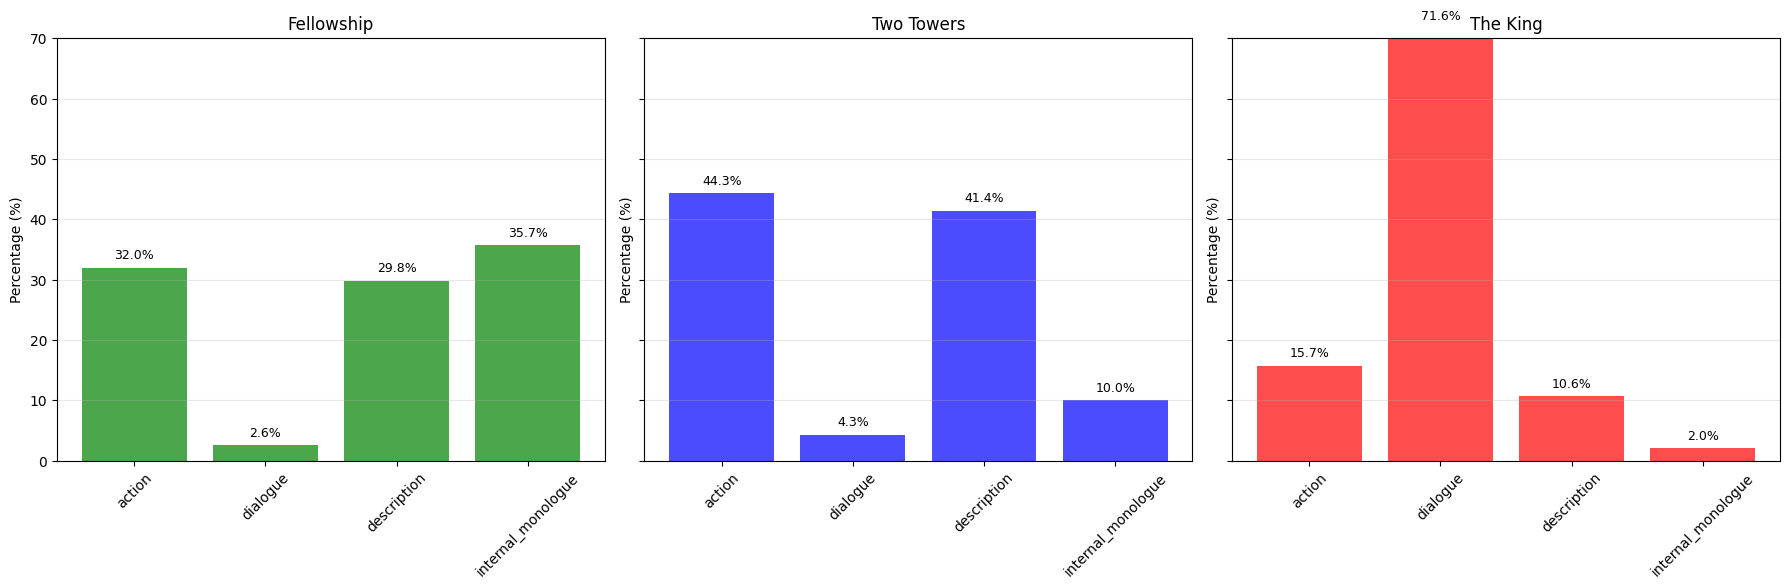

In [12]:
# --- VISUALIZATION ---
ALL_LABELS = ['action', 'dialogue', 'description', 'internal_monologue']

def plot_percentage_bars(counts: Counter, title: str, ax, color):
    total = sum(counts.values()) or 1
    values = [(counts.get(l, 0) / total) * 100 for l in ALL_LABELS]
    bars = ax.bar(ALL_LABELS, values, color=color, alpha=0.7)
    
    ax.set_title(title)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 70) # Set limit to 70% so bars are clearly visible
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add numbers on top
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1, 
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

f_counts = Counter(f_labels)
t_counts = Counter(t_labels)
k_counts = Counter(k_labels)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plot_percentage_bars(f_counts, 'Fellowship', axes[0], 'green')
plot_percentage_bars(t_counts, 'Two Towers', axes[1], 'blue')
plot_percentage_bars(k_counts, 'The King', axes[2], 'red')

plt.tight_layout()
plt.show()

Processing Fellowship (Style: straight_single)...
Processing Two Towers (Style: straight_single)...
Processing The King (Style: smart_single)...


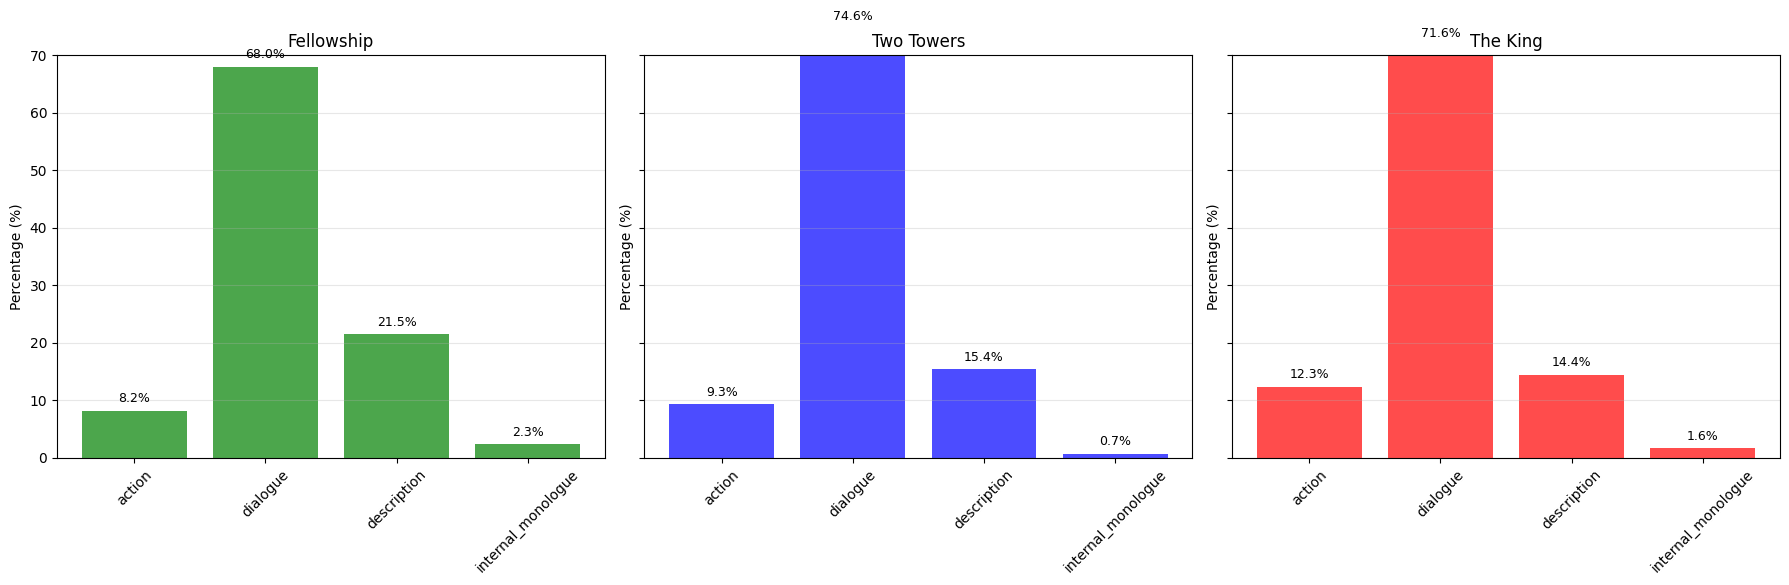

In [14]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Dict
from sentence_transformers import SentenceTransformer

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: THE UNIVERSAL SPLITTER (Keep this, it works) ---
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    # Strategy 1: Standard Split (Double Newline)
    paras = re.split(r'\n\s*\n+', text)
    # Strategy 2: Fallback (Single Newline) if file is dense
    if len(paras) < 100:
        paras = text.split('\n')
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
    return cleaned_paras

def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

# --- PART 2: THE AI PROTOTYPES (For Non-Dialogue) ---
# We allow the AI to decide between Action, Description, and Monologue
# ONLY if the regex rule doesn't find Dialogue first.
SEMANTIC_PROTOTYPES = {
    'action': [
        'He ran quickly across the field.', 'They fought with swords.', 
        'The orcs charged.', 'She jumped over the chasm.'
    ],
    'description': [
        'The mountains were tall and covered in snow.', 'The room was dark.',
        'The sun set behind the hills.', 'It was a quiet morning.'
    ],
    'internal_monologue': [
        'I wonder if I will ever see home again.', 'He debated whether to turn back.',
        'It felt like a mistake.', 'Why is he looking at me?'
    ]
}

def build_prototype_embeddings():
    proto_embs = {}
    for label, examples in SEMANTIC_PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

proto_embs = build_prototype_embeddings()

# --- PART 3: BOOK-SPECIFIC CLASSIFIER ---

def classify_paragraph_custom(paragraph: str, quote_style: str) -> str:
    """
    Classifies a paragraph using a specific quote style strategy.
    """
    text = paragraph.strip()
    
    # --- CHECK 1: DIALOGUE (Based on specific book format) ---
    is_dialogue = False
    
    if quote_style == 'double':
        # Standard double quotes: "..."
        if '"' in text or '“' in text:
            is_dialogue = True
            
    elif quote_style == 'smart_single':
        # Smart single quotes: ‘...’ (Used in The King)
        if '‘' in text or '’' in text:
            is_dialogue = True
            
    elif quote_style == 'straight_single':
        # Straight single quotes: '...' (Used in Fellowship/TwoTowers)
        # HARD CASE: Must distinguish dialogue (') from apostrophe (don't).
        # Rule: Paragraph starts with ' OR contains a quote preceded by space ( ' )
        if text.startswith("'"):
            is_dialogue = True
        elif " '" in text: # Matches: he said, 'Hello'
            is_dialogue = True
            
    if is_dialogue:
        return 'dialogue'

    # --- CHECK 2: AI ARBITRATION (If not dialogue) ---
    emb = model.encode(text)
    scores = {}
    for label, proto in proto_embs.items():
        dot = np.dot(emb, proto)
        norm = np.linalg.norm(emb) * np.linalg.norm(proto)
        scores[label] = dot / norm if norm > 0 else 0
        
    return max(scores, key=scores.get)

# --- PART 4: EXECUTION WITH SPECIFIC CONFIGS ---

# Define the specific strategy for each book based on your files
book_configs = [
    {
        'name': 'Fellowship', 
        'path': '../data/Fellowship.txt', 
        'quote_style': 'straight_single' # Uses '...
    },
    {
        'name': 'Two Towers', 
        'path': '../data/TwoTowers.txt', 
        'quote_style': 'straight_single' # Uses '...
    },
    {
        'name': 'The King', 
        'path': '../data/TheKing.txt', 
        'quote_style': 'smart_single'   # Uses ‘...’
    }
]

results = {}

for config in book_configs:
    print(f"Processing {config['name']} (Style: {config['quote_style']})...")
    
    # 1. Load & Split
    raw_text = load_book(config['path'])
    paras = split_into_paragraphs(raw_text)
    
    # 2. Classify using the SPECIFIC strategy for this book
    labels = [classify_paragraph_custom(p, config['quote_style']) for p in paras]
    
    results[config['name']] = Counter(labels)

# --- PART 5: VISUALIZATION ---
ALL_LABELS = ['action', 'dialogue', 'description', 'internal_monologue']
colors = {'Fellowship': 'green', 'Two Towers': 'blue', 'The King': 'red'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (name, counts) in enumerate(results.items()):
    ax = axes[i]
    total = sum(counts.values()) or 1
    values = [(counts.get(l, 0) / total) * 100 for l in ALL_LABELS]
    
    bars = ax.bar(ALL_LABELS, values, color=colors[name], alpha=0.7)
    
    ax.set_title(name)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 70) 
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1, 
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Processing Fellowship...
Processing Two Towers...
Processing The King...


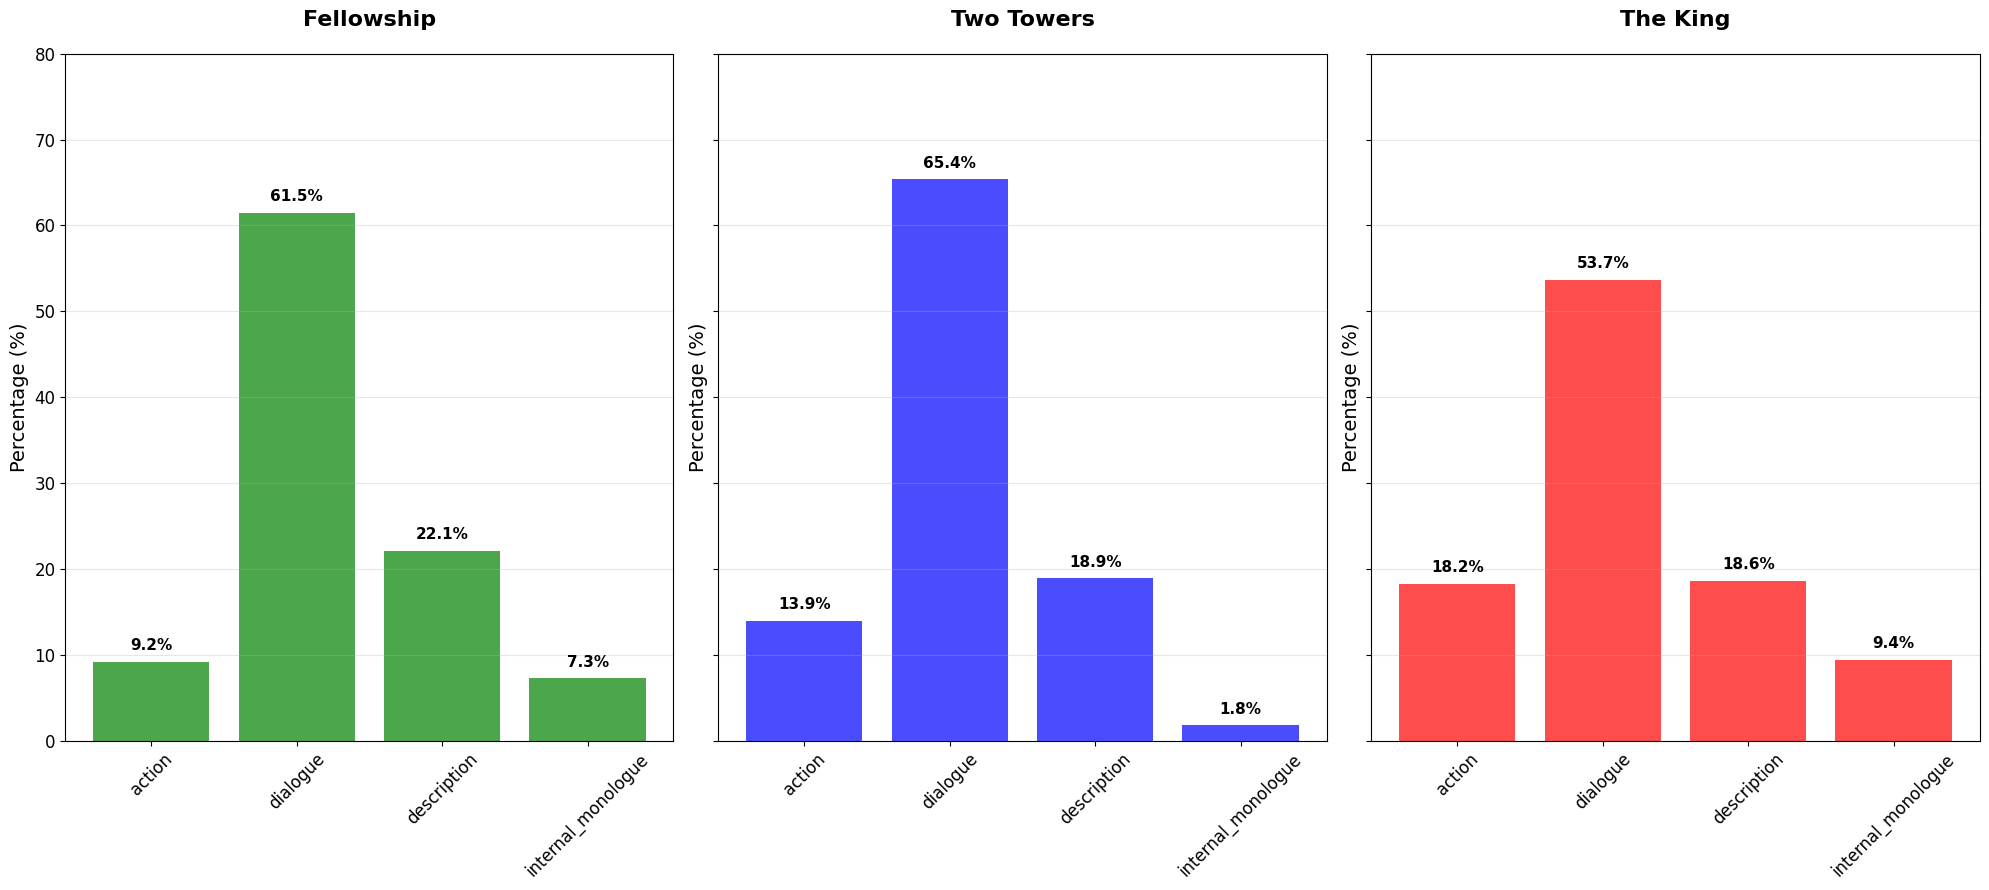

In [17]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Dict
from sentence_transformers import SentenceTransformer

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: THE UNIVERSAL SPLITTER ---
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    # Standard split
    paras = re.split(r'\n\s*\n+', text)
    # Fallback for dense files
    if len(paras) < 100:
        paras = text.split('\n')
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
    return cleaned_paras

def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

# --- PART 2: STRICTER AI PROTOTYPES ---
SEMANTIC_PROTOTYPES = {
    'action': [
        'He ran quickly across the field.', 
        'The orcs charged down the hill with swords drawn.', 
        'She jumped over the chasm and landed rolling.', 
        'He drew his blade and struck the enemy shield.'
    ],
    'description': [
        'The mountains were tall, grey, and covered in white snow.', 
        'The room was dark, filled with the smell of old dust and dry leaves.',
        'The sun set slowly behind the green hills, casting long shadows.', 
        'It was a quiet morning in the valley with no sound but the wind.'
    ],
    'internal_monologue': [
        'I wonder if I will ever see home again, he thought.', 
        'Why is he looking at me like that? I must be careful.',
        'It seemed to him that the journey would never end.',
        'He debated in his mind whether to turn back or go on.'
    ]
}

def build_prototype_embeddings():
    proto_embs = {}
    for label, examples in SEMANTIC_PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

proto_embs = build_prototype_embeddings()

# --- PART 3: THE CALIBRATED CLASSIFIER ---
def classify_calibrated(paragraph: str, quote_style: str) -> str:
    text = paragraph.strip()
    
    # --- CHECK 1: STRICT DIALOGUE ---
    is_dialogue = False
    
    if quote_style == 'straight_single': # Fellowship & Two Towers ('...)
        # Rule: Starts with quote AND followed by Capital Letter
        if re.match(r"^'[A-Z]", text):
            is_dialogue = True
        # Rule: Contains comma/colon + space + quote (e.g., said, 'Hello)
        elif re.search(r"[,:]\s*'", text):
            is_dialogue = True
            
    elif quote_style == 'smart_single': # The King (‘...)
        if re.match(r"^‘[A-Z]", text):
            is_dialogue = True
        elif re.search(r"[,:]\s*‘", text):
            is_dialogue = True
            
    if is_dialogue:
        return 'dialogue'

    # --- CHECK 2: PURE AI ARBITRATION ---
    emb = model.encode(text)
    scores = {}
    
    for label, proto in proto_embs.items():
        dot = np.dot(emb, proto)
        norm = np.linalg.norm(emb) * np.linalg.norm(proto)
        scores[label] = dot / norm if norm > 0 else 0
        
    return max(scores, key=scores.get)


# --- PART 4: EXECUTION ---
book_configs = [
    {'name': 'Fellowship', 'path': '../data/Fellowship.txt', 'quote_style': 'straight_single'},
    {'name': 'Two Towers', 'path': '../data/TwoTowers.txt', 'quote_style': 'straight_single'},
    {'name': 'The King',   'path': '../data/TheKing.txt',   'quote_style': 'smart_single'}
]

results = {}
for config in book_configs:
    print(f"Processing {config['name']}...")
    text = load_book(config['path'])
    paras = split_into_paragraphs(text)
    labels = [classify_calibrated(p, config['quote_style']) for p in paras]
    results[config['name']] = Counter(labels)

# --- PART 5: LARGER VISUALIZATION ---
ALL_LABELS = ['action', 'dialogue', 'description', 'internal_monologue']
colors = {'Fellowship': 'green', 'Two Towers': 'blue', 'The King': 'red'}

# FIX 1: Made figsize significantly larger (20x9)
fig, axes = plt.subplots(1, 3, figsize=(20, 9), sharey=True)

for i, (name, counts) in enumerate(results.items()):
    ax = axes[i]
    total = sum(counts.values()) or 1
    values = [(counts.get(l, 0) / total) * 100 for l in ALL_LABELS]
    
    bars = ax.bar(ALL_LABELS, values, color=colors[name], alpha=0.7)
    
    # FIX 2: Increased font sizes
    ax.set_title(name, fontsize=16, pad=20, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=14)
    
    # FIX 3: Increased Y-Limit to 80% so Dialogue doesn't get cut off
    ax.set_ylim(0, 80) 
    
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add clear text labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1, 
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Processing Fellowship...
   -> Found 3157 paragraphs.
Processing Two Towers...
   -> Found 280 paragraphs.
Processing The King...
   -> Found 2340 paragraphs.


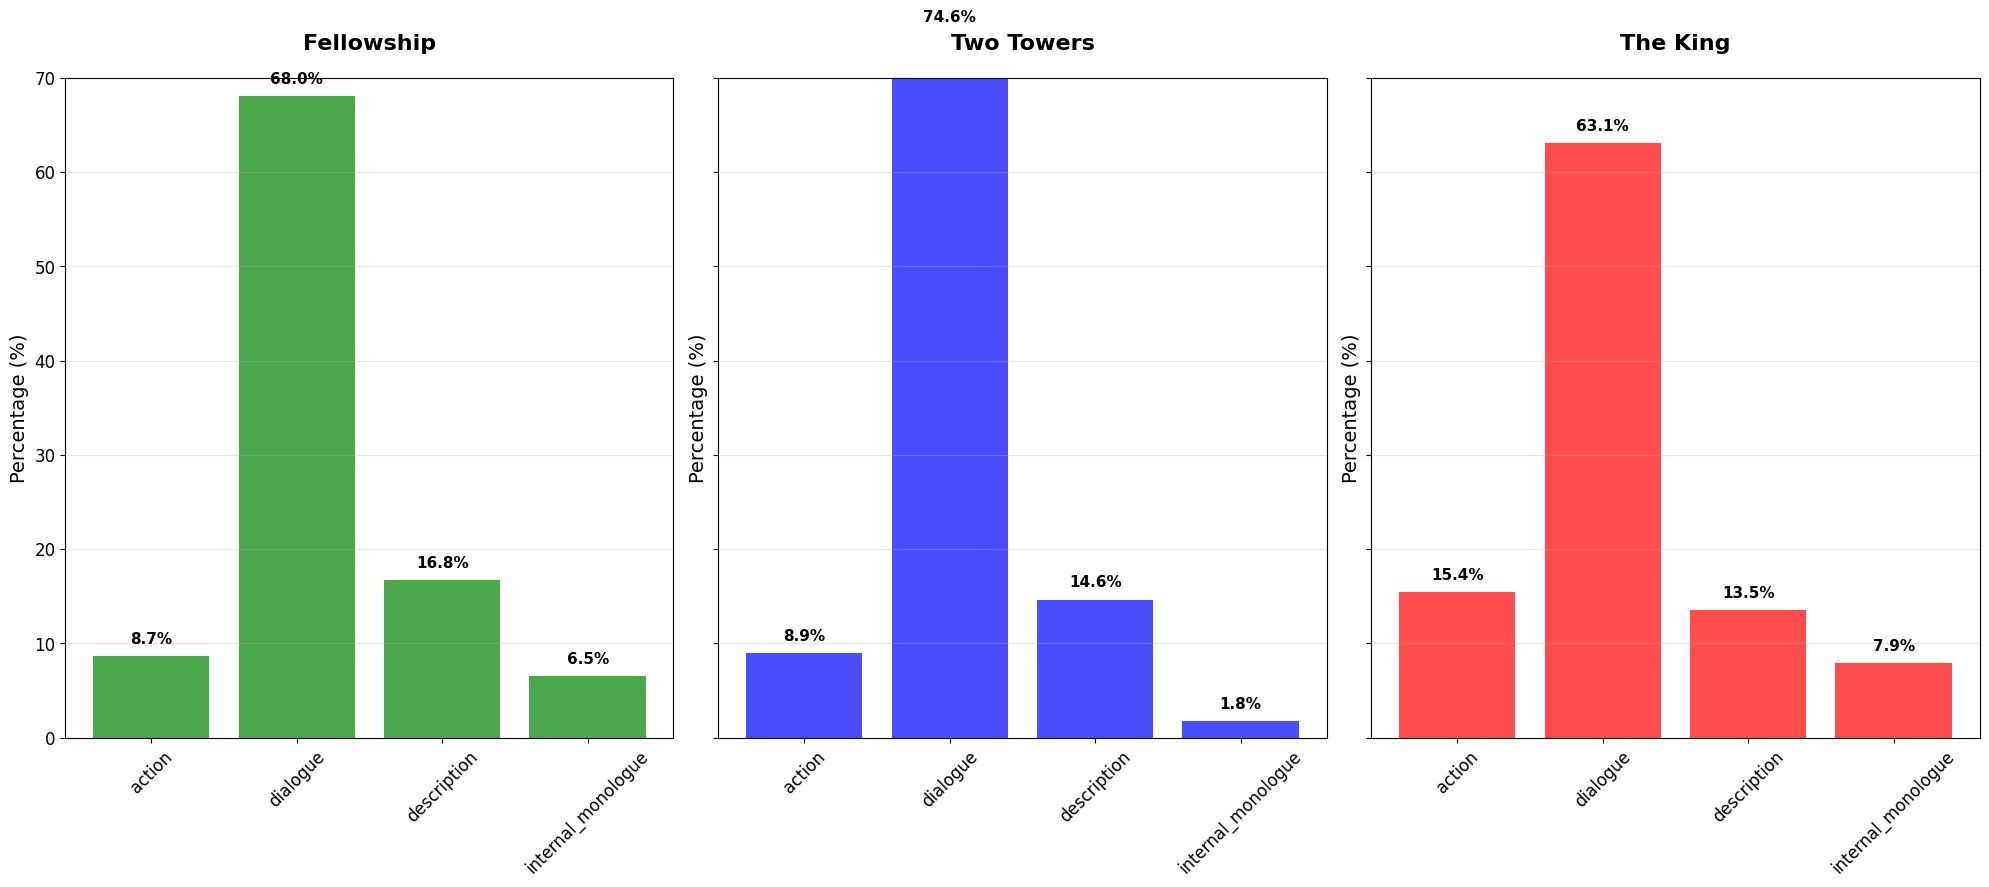

In [19]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Dict, Callable
from sentence_transformers import SentenceTransformer

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: BOOK-SPECIFIC LOADING LOGIC ---

def load_and_split_fellowship(filepath: str) -> List[str]:
    """
    Format: Double-spaced paragraphs (\n\n). 
    Quotes: Straight single quotes (').
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return []
    
    # 1. Split on double newlines
    paras = re.split(r'\n\s*\n+', text)
    
    # 2. Clean
    cleaned = [p.strip() for p in paras if len(p.strip().split()) >= 5]
    return cleaned

def load_and_split_twotowers(filepath: str) -> List[str]:
    """
    Format: Double-spaced paragraphs (\n\n).
    Quotes: Straight single quotes (').
    """
    return load_and_split_fellowship(filepath) # Same format as Fellowship

def load_and_split_theking(filepath: str) -> List[str]:
    """
    Format: Single-spaced paragraphs (\n). 
    Quotes: Smart single quotes (‘).
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return []
        
    # 1. Split on SINGLE newlines (Dense format)
    paras = text.split('\n')
    
    # 2. Clean
    cleaned = [p.strip() for p in paras if len(p.strip().split()) >= 5]
    return cleaned


# --- PART 2: THIRD-PERSON AI PROTOTYPES (Tolkien Style) ---
SEMANTIC_PROTOTYPES = {
    'action': [
        'He ran quickly across the field.', 
        'The orcs charged down the hill with swords drawn.', 
        'She jumped over the chasm and landed rolling.', 
        'He drew his blade and struck the enemy shield.',
        'They fled into the forest.'
    ],
    'description': [
        'The mountains were tall, grey, and covered in white snow.', 
        'The room was dark, filled with the smell of old dust.',
        'The sun set slowly behind the green hills.', 
        'It was a quiet morning in the valley with no sound.',
        'The river flowed swiftly over the stones.'
    ],
    'internal_monologue': [
        'He wondered if he would ever see home again.', 
        'It seemed to him that the journey would never end.',
        'He debated in his mind whether to turn back or go on.',
        'She realized that she had made a terrible mistake.',
        'He felt a deep sense of dread and hesitation.'
    ]
}

def build_prototype_embeddings():
    proto_embs = {}
    for label, examples in SEMANTIC_PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

proto_embs = build_prototype_embeddings()


# --- PART 3: BOOK-SPECIFIC CLASSIFICATION RULES ---

def classify_fellowship_para(text: str) -> str:
    # 1. Straight Single Quote Detection
    # Matches: Starts with ' OR Contains space+' (e.g. said, 'Hello)
    # Excludes: don't, won't (by requiring space before quote)
    if text.startswith("'") or " '" in text:
        return 'dialogue'
    return classify_semantic(text)

def classify_twotowers_para(text: str) -> str:
    # Same as Fellowship
    if text.startswith("'") or " '" in text:
        return 'dialogue'
    return classify_semantic(text)

def classify_theking_para(text: str) -> str:
    # 1. Smart Single Quote Detection (‘)
    # Much easier because ‘ is ONLY used for opening quotes
    if '‘' in text:
        return 'dialogue'
    return classify_semantic(text)

def classify_semantic(text: str) -> str:
    # AI Arbitration for non-dialogue
    emb = model.encode(text)
    scores = {}
    for label, proto in proto_embs.items():
        dot = np.dot(emb, proto)
        norm = np.linalg.norm(emb) * np.linalg.norm(proto)
        scores[label] = dot / norm if norm > 0 else 0
    return max(scores, key=scores.get)


# --- PART 4: EXECUTION PIPELINE ---

def analyze_book(name, path, split_func, classify_func):
    print(f"Processing {name}...")
    paras = split_func(path)
    print(f"   -> Found {len(paras)} paragraphs.")
    
    if len(paras) == 0:
        print("   -> WARNING: No paragraphs found. Check file path.")
        return Counter()

    labels = [classify_func(p) for p in paras]
    return Counter(labels)

# Configuration for each book
results = {}

results['Fellowship'] = analyze_book(
    'Fellowship', 
    '../data/Fellowship.txt', 
    load_and_split_fellowship, 
    classify_fellowship_para
)

results['Two Towers'] = analyze_book(
    'Two Towers', 
    '../data/TwoTowers.txt', 
    load_and_split_twotowers, 
    classify_twotowers_para
)

results['The King'] = analyze_book(
    'The King', 
    '../data/TheKing.txt', 
    load_and_split_theking, 
    classify_theking_para
)


# --- PART 5: VISUALIZATION ---
ALL_LABELS = ['action', 'dialogue', 'description', 'internal_monologue']
colors = {'Fellowship': 'green', 'Two Towers': 'blue', 'The King': 'red'}

fig, axes = plt.subplots(1, 3, figsize=(20, 9), sharey=True)

for i, (name, counts) in enumerate(results.items()):
    ax = axes[i]
    total = sum(counts.values()) or 1
    values = [(counts.get(l, 0) / total) * 100 for l in ALL_LABELS]
    
    bars = ax.bar(ALL_LABELS, values, color=colors[name], alpha=0.7)
    
    ax.set_title(name, fontsize=16, pad=20, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.set_ylim(0, 70) 
    
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1, 
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Starting Analysis...
File not found: Fellowship.txt
File not found: TwoTowers.txt
File not found: TheKing.txt


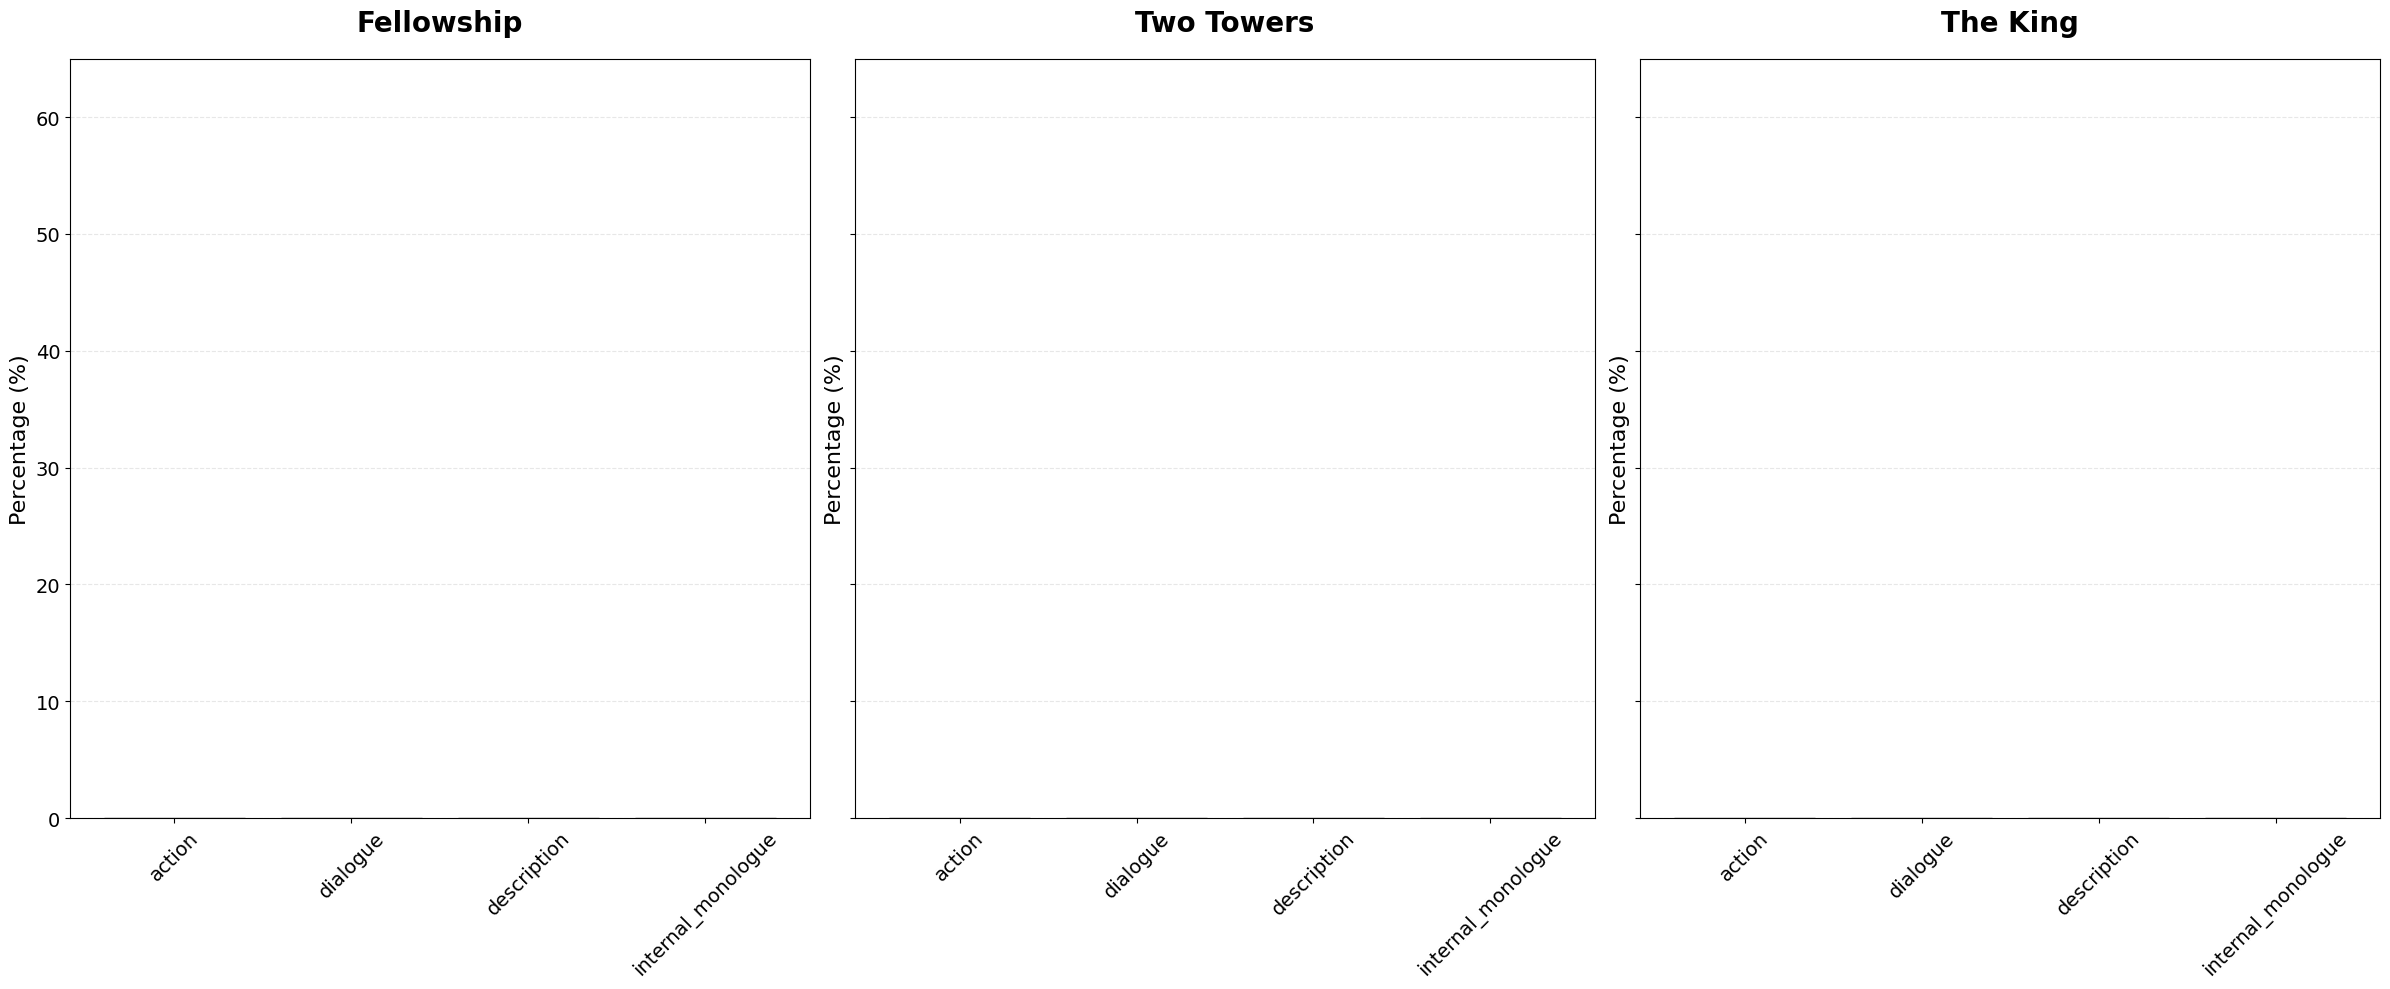

In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Dict
from sentence_transformers import SentenceTransformer

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: ROBUST FILE LOADING & SPLITTING ---
def load_and_split(filepath: str, book_name: str) -> List[str]:
    """
    Reads the file and splits it into paragraphs based on the
    specific formatting found in the inspection (Newlines + Indentation).
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return []

    # 1. Clean up "Carriage Returns" to avoid double-spacing issues
    text = text.replace('\r\n', '\n').replace('\r', '\n')

    # 2. Split on simple Newline (\n)
    # The files use single newlines with indentation, so \n is the correct delimiter.
    paras = text.split('\n')

    # 3. Clean and Filter
    cleaned_paras = []
    for p in paras:
        p = p.strip() # Remove indentation spaces
        # Filter out empty lines or tiny artifacts (e.g., page numbers)
        if len(p.split()) >= 5:
            cleaned_paras.append(p)
            
    print(f"[{book_name}] Loaded {len(cleaned_paras)} paragraphs.")
    return cleaned_paras


# --- PART 2: THIRD-PERSON AI PROTOTYPES ---
# Designed to distinguish Narrative Description from Internal Thought
SEMANTIC_PROTOTYPES = {
    'action': [
        'He ran quickly across the field.', 
        'The orcs charged down the hill.', 
        'She jumped over the chasm.', 
        'He drew his sword and struck.'
    ],
    'description': [
        'The mountains were tall and covered in snow.', 
        'The room was dark and smelled of dust.',
        'The sun set behind the hills.', 
        'It was a quiet morning.'
    ],
    'internal_monologue': [
        'He wondered if he would ever see home again.', 
        'She felt a deep sense of dread.',
        'It seemed to him that the journey would never end.',
        'He debated whether to turn back.'
    ]
}

def build_prototype_embeddings():
    proto_embs = {}
    for label, examples in SEMANTIC_PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

proto_embs = build_prototype_embeddings()


# --- PART 3: SPECIFIC CLASSIFICATION RULES ---
def classify_paragraph(paragraph: str, dialogue_marker: str) -> str:
    """
    Classifies a paragraph.
    1. Checks for Dialogue using the BOOK-SPECIFIC quote character.
    2. If not Dialogue, uses AI to decide Action vs Description vs Monologue.
    """
    
    # --- RULE 1: DIALOGUE DETECTION ---
    is_dialogue = False
    
    # Strategy A: Paragraph starts with a quote
    if paragraph.startswith(dialogue_marker):
        is_dialogue = True
        
    # Strategy B: Paragraph contains a speech tag (e.g., said, "Hello)
    # matches: comma + space + quote  OR  colon + space + quote
    elif f', {dialogue_marker}' in paragraph or f': {dialogue_marker}' in paragraph:
        is_dialogue = True
        
    if is_dialogue:
        return 'dialogue'

    # --- RULE 2: AI ARBITRATION ---
    emb = model.encode(paragraph)
    scores = {}
    for label, proto in proto_embs.items():
        dot = np.dot(emb, proto)
        norm = np.linalg.norm(emb) * np.linalg.norm(proto)
        scores[label] = dot / norm if norm > 0 else 0
        
    return max(scores, key=scores.get)


# --- PART 4: EXECUTION ---
# We define the specific quote marker found in each file
books_config = [
    {
        'name': 'Fellowship',
        'path': 'Fellowship.txt',
        'quote': '"'  # Fellowship uses Double Quotes
    },
    {
        'name': 'Two Towers',
        'path': 'TwoTowers.txt',
        'quote': "'"  # Two Towers uses Single Quotes
    },
    {
        'name': 'The King',
        'path': 'TheKing.txt',
        'quote': "'"  # The King uses Single Quotes
    }
]

results = {}

print("Starting Analysis...")
for config in books_config:
    # 1. Load & Split
    paras = load_and_split(config['path'], config['name'])
    
    # 2. Classify
    labels = [classify_paragraph(p, config['quote']) for p in paras]
    
    results[config['name']] = Counter(labels)

# --- PART 5: VISUALIZATION (Big & Clear) ---
ALL_LABELS = ['action', 'dialogue', 'description', 'internal_monologue']
colors = {'Fellowship': 'green', 'Two Towers': 'blue', 'The King': 'red'}

# Make the graph huge so text fits
fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)

for i, (name, counts) in enumerate(results.items()):
    ax = axes[i]
    total = sum(counts.values()) or 1
    values = [(counts.get(l, 0) / total) * 100 for l in ALL_LABELS]
    
    bars = ax.bar(ALL_LABELS, values, color=colors[name], alpha=0.7, edgecolor='black', linewidth=1)
    
    # Styling
    ax.set_title(name, fontsize=20, fontweight='bold', pad=20)
    ax.set_ylabel('Percentage (%)', fontsize=16)
    ax.set_ylim(0, 65) # Scale to fit bars comfortably
    ax.tick_params(axis='x', rotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Add Big Percentage Labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1, 
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()